In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import tensorflow as tf

In [3]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

In [4]:
def extract_skeleton_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frames_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Chuyển đổi BGR sang RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Phát hiện pose
        results = pose.process(frame_rgb)
        
        if results.pose_landmarks:
            # Lấy các điểm landmark (33 điểm, mỗi điểm có x,y,z)
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark])
            frames_landmarks.append(landmarks.flatten())
    
    cap.release()
    
    # Chuẩn hóa số frame về cùng một độ dài
    if len(frames_landmarks) > 0:
        frames_landmarks = np.array(frames_landmarks)
        # Lấy 30 frame đều nhau từ video
        target_frames = 30
        if len(frames_landmarks) >= target_frames:
            indices = np.linspace(0, len(frames_landmarks)-1, target_frames, dtype=int)
            frames_landmarks = frames_landmarks[indices]
        else:
            # Padding nếu video quá ngắn
            padding = np.zeros((target_frames - len(frames_landmarks), frames_landmarks.shape[1]))
            frames_landmarks = np.vstack((frames_landmarks, padding))
        
        return frames_landmarks
    return None

def load_dataset(data_path):
    X = []
    y = []
    
    # Lặp qua các thư mục class
    classes = sorted(os.listdir(data_path))
    print("Loading dataset...")
    
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # Lặp qua các video trong class
        for video_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            video_path = os.path.join(class_path, video_name)
            
            # Trích xuất đặc trưng skeleton
            features = extract_skeleton_features(video_path)
            
            if features is not None:
                X.append(features)
                y.append(class_name)
    
    X = np.array(X)
    y = np.array(y)
    
    # Encode nhãn
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y)
    
    return X, y, le

def build_model(input_shape, num_classes):  
    """
    Xây dựng mô hình CNN-LSTM
    """
    model = Sequential([
        # CNN layers
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        
        # LSTM layers
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        
        LSTM(64),
        Dropout(0.3),
        
        # Dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def plot_training_history(history):
    """
    Vẽ đồ thị accuracy và loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_encoder):
    """
    Vẽ confusion matrix
    """
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def save_model(model, model_path, label_encoder, label_encoder_path):
    """
    Lưu model và label encoder
    """
    # Lưu model
    model.save(model_path)
    
    # Lưu label encoder
    with open(label_encoder_path, 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print(f"Đã lưu model tại: {model_path}")
    print(f"Đã lưu label encoder tại: {label_encoder_path}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
data_path = '/kaggle/input/dataset'

In [6]:
X, y, label_encoder = load_dataset(data_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

Loading dataset...


Processing falling_down:   0%|          | 0/100 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
W0000 00:00:1731831477.495656     110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731831477.561789     111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731831477.596902     113 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Processing stand_up: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


In [7]:
model = build_model(input_shape, num_classes)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Training model...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.3045 - loss: 1.9733 - val_accuracy: 0.3071 - val_loss: 1.9167
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5784 - loss: 1.2028 - val_accuracy: 0.2786 - val_loss: 1.9031
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7013 - loss: 0.8714 - val_accuracy: 0.1786 - val_loss: 1.8691
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7694 - loss: 0.6965 - val_accuracy: 0.2714 - val_loss: 1.8219
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7902 - loss: 0.5763 - val_accuracy: 0.3000 - val_loss: 1.8090
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8142 - loss: 0.5288 - val_accuracy: 0.1571 - val_loss: 1.8299
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8315 - loss: 0.4665 - val_accuracy: 0.1786 - val_loss: 1.8058
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8853 - loss: 0.3394 - val_ac

In [9]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)

# In classification report
print("\nClassification Report:")
print(classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    target_names=label_encoder.classes_
))


Evaluating model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2909 

Test accuracy: 0.9000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step

Classification Report:
              precision    recall  f1-score   support

falling_down       1.00      1.00      1.00        25
     jump_up       0.96      1.00      0.98        22
     kicking       0.81      0.81      0.81        21
       punch       0.76      0.65      0.70        20
     running       0.80      0.86      0.83        14
    sit_down       1.00      0.94      0.97        18
    stand_up       0.91      1.00      0.95        20

    accuracy                           0.90       140
   macro avg       0.89      0.89      0.89       140
weighted avg       0.90      0.90      0.90       140



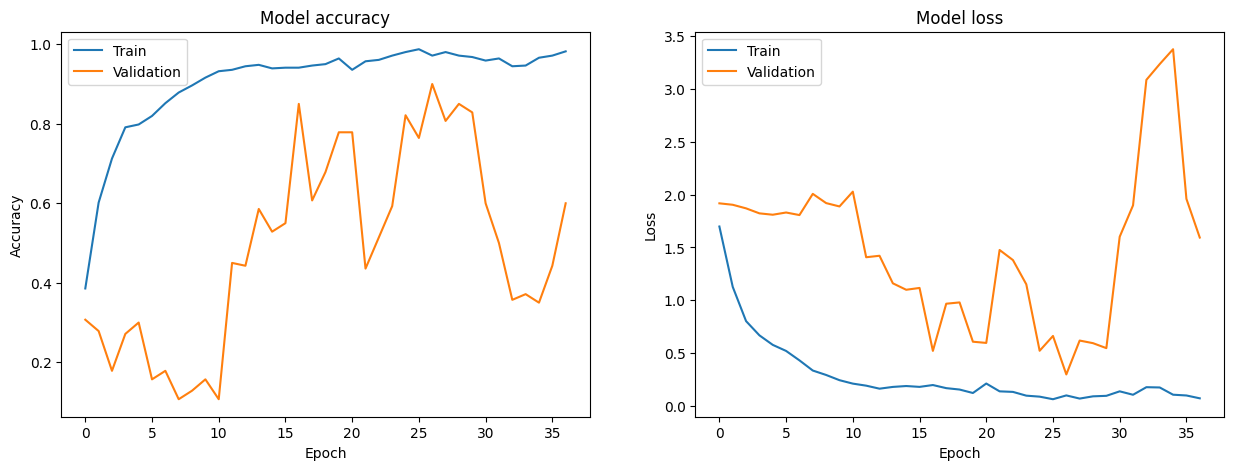

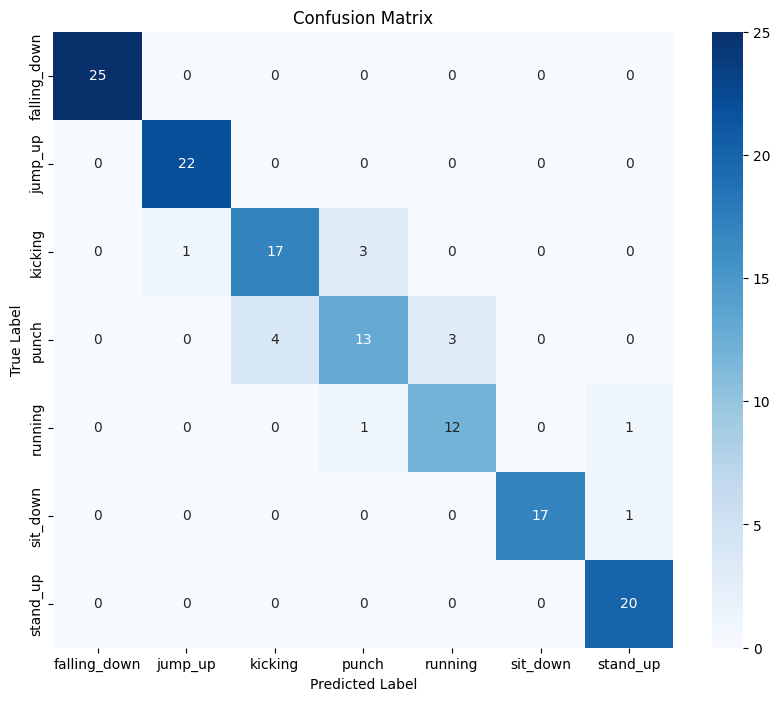

Đã lưu model tại: action_recognition_model.keras
Đã lưu label encoder tại: label_encoder.pkl


In [11]:
plot_training_history(history)

plot_confusion_matrix(y_test, y_pred, label_encoder)

model_path = 'action_recognition_model.keras'
label_encoder_path = 'label_encoder.pkl'
save_model(model, model_path, label_encoder, label_encoder_path)